# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**Trend Elements**:

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.


**Seasonal Elements**:

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- S: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.


**SARIMA notation**: SARIMA(p,d,q)(P,D,Q,S)


Let's try to apply it to the Airline Passengers.

First, let's import all the library we need.

In [1]:
import warnings

from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.tsa.api as smt
import statsmodels.api as sm

We import the dataset:

In [2]:
# import data
data_set = pd.read_csv('data/airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

/var/folders/3k/djbzqdt5427f47w1g2w616jh0000gn/T/ipykernel_87779/1111429817.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_set = pd.read_csv('data/airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])


In [3]:
train = data_set[:'1957-01-01'].copy().rename(columns={"Thousands of Passengers": "train"})
test = data_set['1957-01-02':].copy().rename(columns={"Thousands of Passengers": "test"})

Prepare the evaluation functions:

In [4]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(y_true, y_pred):
    print("MAE:",mae(y_true, y_pred))
    print("MSE:", mse(y_true, y_pred))
    print("RMSE:", np.sqrt(mse(y_true, y_pred)))
    print("MAPE:", mape(y_true, y_pred))

In order to have baselines, let's pick up the results we obtained previously for the Persistent, the Holt and the Holt-Winters models:

In [5]:
test['Persistent'] = test['test'].shift(1)
evaluate(test['test'][1:], test['test'].shift(1)[1:])

MAE: 41.28260869565217
MSE: 2402.282608695652
RMSE: 49.01308609642584
MAPE: 9.87598070824141


In [6]:
warnings.filterwarnings("ignore") # suppress warnings

fitHolt = Holt(train['train']).fit(smoothing_level = 0.2,smoothing_trend = 0.05)
test['Holt'] = fitHolt.forecast(len(test))
evaluate(test['test'], test['Holt'])

MAE: 51.68541558444403
MSE: 4765.143213045756
RMSE: 69.03001675391478
MAPE: 11.639792901174767


In [7]:
warnings.filterwarnings("ignore") # suppress warnings

fitTES = ExponentialSmoothing(train['train'] ,seasonal_periods=12 ,trend='add', seasonal='add',use_boxcox=True,initialization_method="estimated").fit()
test['Holt-Winters'] = fitTES.forecast(len(test))
evaluate(test['test'], test['Holt-Winters'])

MAE: 37.72879073508171
MSE: 2004.9252627786302
RMSE: 44.77639180169199
MAPE: 9.276400635347477


## SARIMA

### Order selection

Let's plot the ACF and PACF in order to find the order for SARIMA:

In [8]:
# function for plotting acf and pacf plot to find the order of ARIMA models
def tsplot(y, lags=26, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

> **Note:**  
> The identification of SARIMA model orders must always be done on a **stationary time series**.  
> This means :
> - **removing the trend** (e.g., by applying `diff()` to remove a linear trend), and  
> - applying a **seasonal difference** (e.g. `diff(12)` for monthly data) to remove seasonality.  
> 
> Once the series is stationary, you can analyze the **ACF** and **PACF** plots to identify the model parameters.

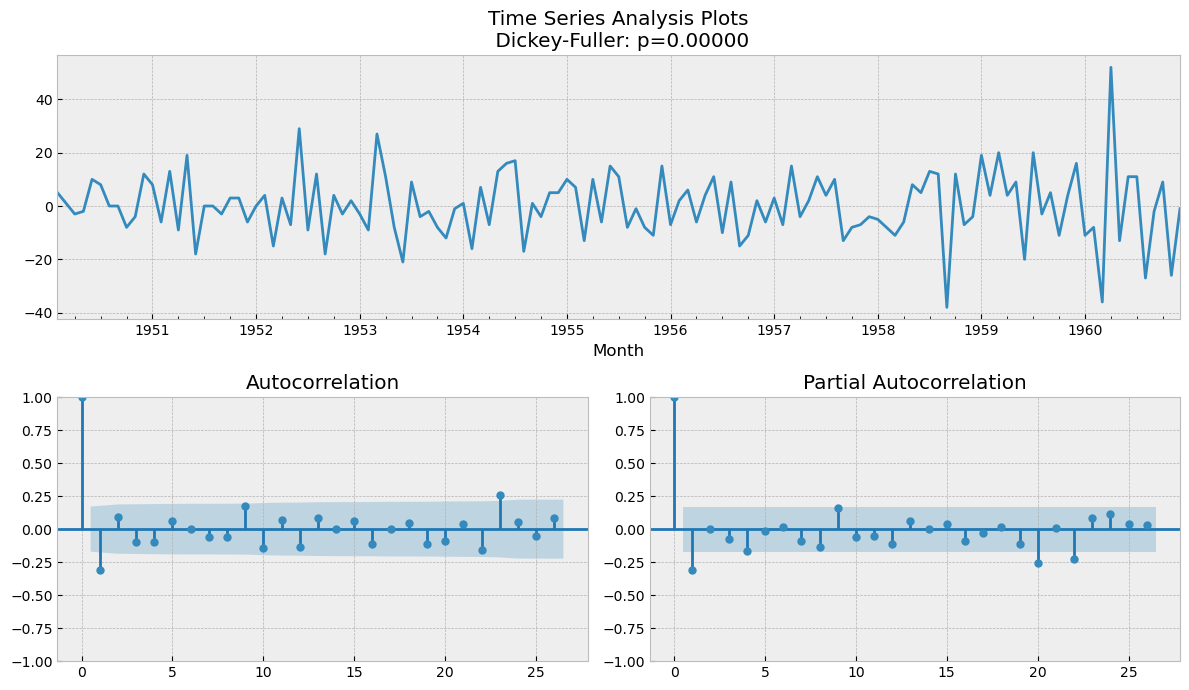

In [9]:
tsplot(data_set['Thousands of Passengers'].diff().diff(12).dropna())

#### **(p, d, q) - Non-seasonal part**
- **p (autoregressive order):** determined from the **PACF**; corresponds to the lag (usually among the first few) where the PACF shows significant spikes before cutting off.  
- **d (order of differencing):** the number of regular differences required to remove the trend and achieve stationarity (commonly 0 or 1).  
- **q (moving average order):** determined from the **ACF**; corresponds to the lag where the ACF shows significant spikes before decaying.

---

#### **(P, D, Q) - Seasonal part**
- **P (seasonal autoregressive order):** determined from the **PACF** at **seasonal lags** (multiples of the seasonal period, e.g. 12, 24, …). A clear spike at lag 12, 24, .. would suggest **P = 1**.  
- **D (seasonal differencing order):** the number of seasonal differences applied to remove repeating seasonal patterns (typically 0 or 1).  
- **Q (seasonal moving average order):** determined from the **ACF** at **seasonal lags**; a spike at lag 12, 24, ... would indicate **Q = 1**.

---

#### **Summary steps**
1. Apply the necessary regular and seasonal differencing to achieve stationarity.  
2. Use ACF and PACF plots of the differenced series to estimate **p, q, P, Q**.  
3. Compare candidate models using **AIC/BIC** and check residuals for white noise.

### Model choice rationale

- **Work on the differenced series (trend + seasonal):** identification is based on ACF/PACF after applying `diff()` and `diff(12)`.

- **Non-seasonal (p, d, q):**
  - Both **ACF(1)** and **PACF(1)** show significant spikes.
  - There is no clear early cut-off (no clean “tail-off”) that would exclude either AR or MA a priori.
  - ⇒ Try **(p, d, q) = (1, 1, 1)**.
 

- **Seasonal (P, D, Q) with S = 12:**
  - No notable spike exactly at **lag 12**.
  - A spike appears at **lag 24 in the ACF**, consistent with seasonal MA behavior across multiples of S.
  - In the **PACF**, spikes at **lags 20 and 22** are not aligned with the seasonal period and can be tentatively ignored.
  - ⇒ Set **(P, D, Q) = (0, 1, 1)** with **S = 12**.

**Candidate model:** **SARIMA (1, 1, 1) × (0, 1, 1, 12)**.

So, one viable option could be: **(1,1,1)x(0,1,1,12)**.

To apply the SARIMA we can use the [SARIMAX](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) object from statsmodels:

In [10]:
model = sm.tsa.statespace.SARIMAX(train['train'],order = (1,1,1),seasonal_order = (0,1,1,12))
results = model.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18194D+00    |proj g|=  4.86351D-02

At iterate    5    f=  3.17824D+00    |proj g|=  2.10959D-02

At iterate   10    f=  3.17735D+00    |proj g|=  4.61320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.942D-06   3.177D+00
  F =   3.1773507943090280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

### Model diagnostic

We can also check the residual in the model diagnostic:

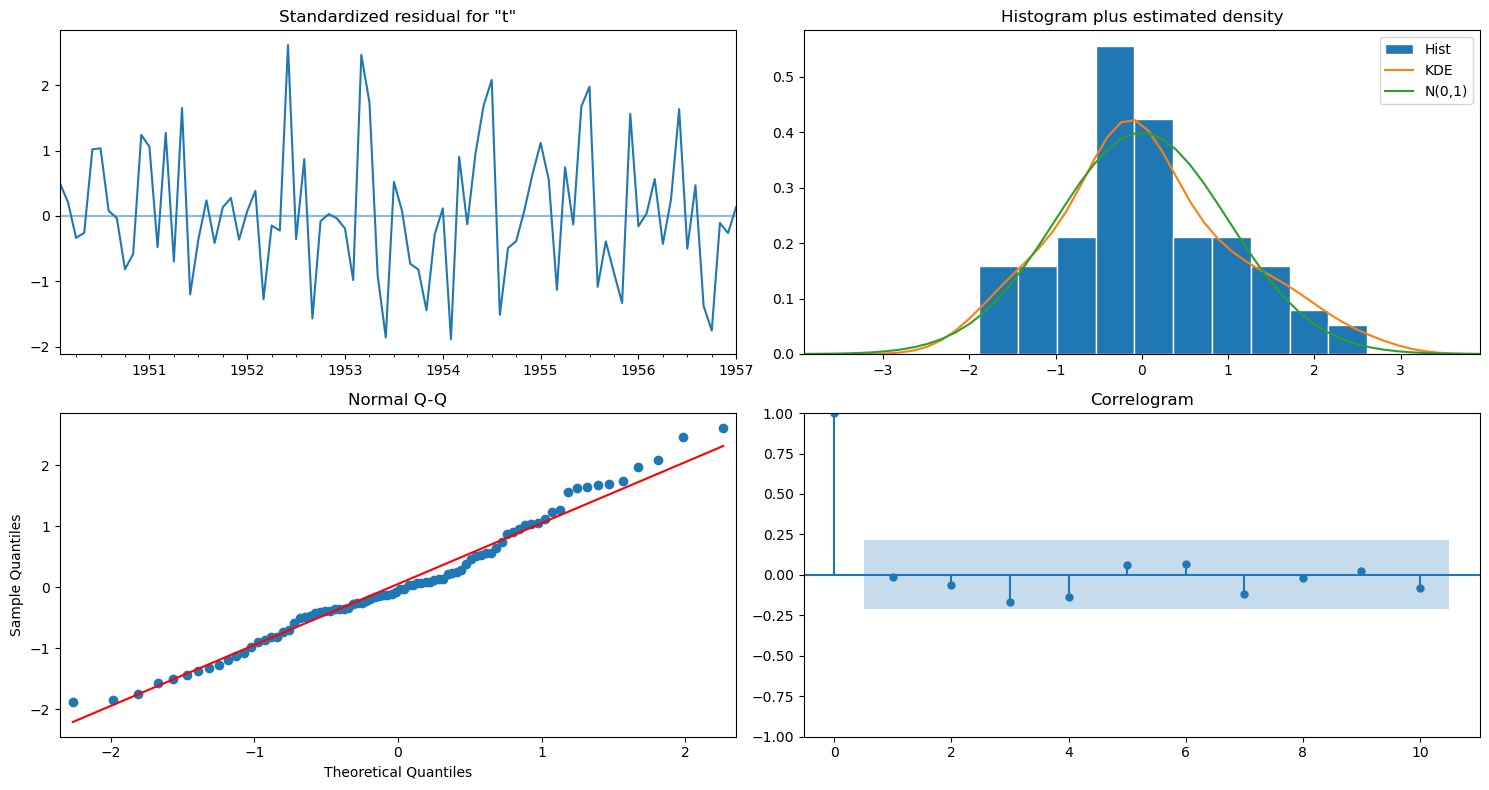

In [11]:
results.plot_diagnostics(figsize=(15,8))
plt.tight_layout()
plt.show()

### Forecasting

Once we passed the model diagnostic phase, we can proceed to make forecast with our model:

In [12]:
test['SARIMA'] = results.predict(start = 97,end = 144,dynamic = False)

In [13]:
evaluate(test['test'], test['SARIMA'])

MAE: 20.00842085593915
MSE: 723.8899879548197
RMSE: 26.905203733754178
MAPE: 4.516694125833797


By comparing SARIMA results with Holt-Winters' ones, we can see that SARIMA significantly outperforms it.

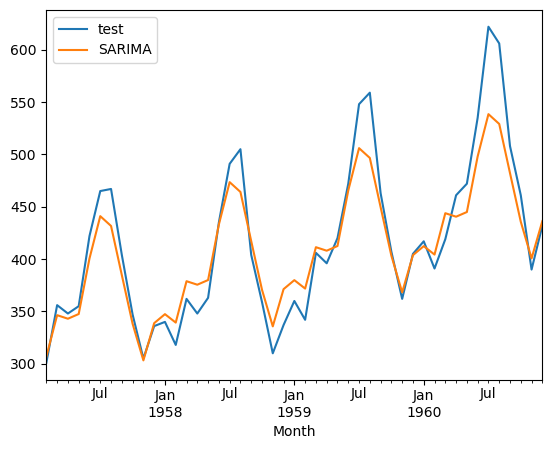

In [14]:
test[['test','SARIMA']].plot()
plt.show()

We can also plot the confidence interval for the prediction

In [15]:
preds_sarima = results.get_prediction(start=97, end=143).summary_frame(alpha=0.05)

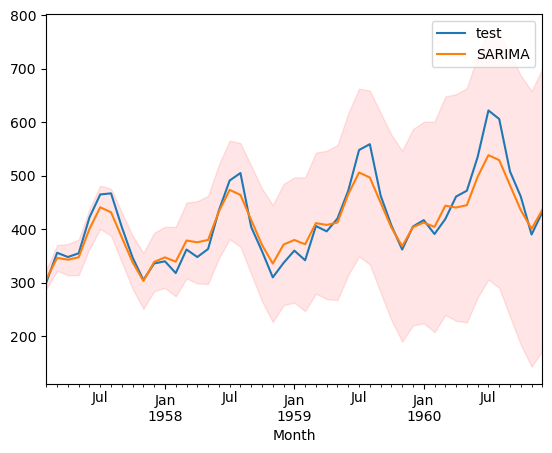

In [16]:
ax = test[['test','SARIMA']].plot()
ax.fill_between(
    preds_sarima.index, preds_sarima['mean_ci_lower'], preds_sarima['mean_ci_upper'],
    color='r', alpha=0.1)
plt.show()

### Optimize order of SARIMA

If we want to search for the best parameters, we can rely on the auto-arima function even for SARIMA, that automatically iterate over the parameters and select the one that has the best AIC value.

In [17]:
from pmdarima.arima import auto_arima

In [18]:
auto_arima(train['train'], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=626.124, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=628.565, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=622.308, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=622.989, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=624.607, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=624.147, Time=0.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=624.218, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=622.896, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=624.620, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=624.204, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=623.797, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=622.415, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=625.731, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
model = sm.tsa.statespace.SARIMAX(train['train'],order = (1,1,0),seasonal_order = (1,1,0,12))
results = model.fit()
evaluate(test['test'], results.predict(start = 97,end = 143))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18030D+00    |proj g|=  5.04770D-02

At iterate    5    f=  3.17689D+00    |proj g|=  7.20950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   4.250D-06   3.177D+00
  F =   3.1768432114071028     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE: 19.701388022652406
MSE: 690.9778399768007
RMSE: 26.286457349304428
MAPE: 4.487206971194725


 This problem is unconstrained.


## SARIMAX

Let's try to add as the exogenous variable the index of the month

In [20]:
train['month_index'] = train.index.month
test['month_index'] = test.index.month

In [21]:
model = sm.tsa.statespace.SARIMAX(train['train'],order = (1,1,0),seasonal_order = (1,1,0,12), exog=train[['month_index']])
results = model.fit()
test['SARIMAX'] = results.predict(start = 97,end = 143, exog=test[['month_index']])
evaluate(test['test'], test['SARIMAX'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18030D+00    |proj g|=  5.04770D-02


 This problem is unconstrained.



At iterate    5    f=  3.17689D+00    |proj g|=  7.20932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   4.240D-06   3.177D+00
  F =   3.1768432113866716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE: 19.701388025490093
MSE: 690.9778399888704
RMSE: 26.286457349534007
MAPE: 4.487206972165746


In [22]:
preds_sarimax = results.get_prediction(start=97, end=143, exog=test[['month_index']]).summary_frame(alpha=0.05)

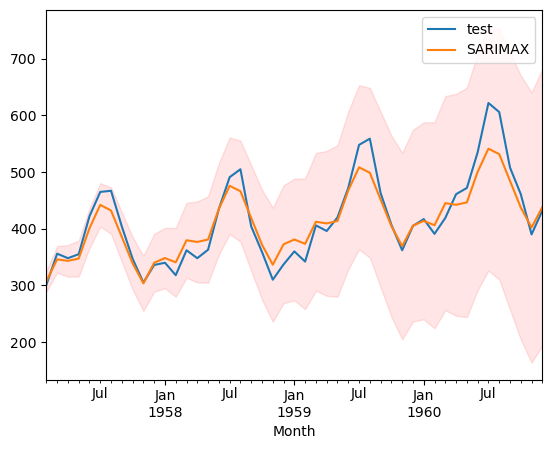

In [23]:
ax = test[['test','SARIMAX']].plot()
ax.fill_between(
    preds_sarimax.index, preds_sarimax['mean_ci_lower'], preds_sarimax['mean_ci_upper'],
    color='r', alpha=0.1)
plt.show()

In [24]:
preds_sarima

train,mean,mean_se,mean_ci_lower,mean_ci_upper
1957-02-01,306.811877,9.458461,288.273633,325.350120
1957-03-01,346.425695,12.168535,322.575806,370.275585
1957-04-01,343.033060,14.967786,313.696739,372.369382
1957-05-01,347.521101,17.015385,314.171559,380.870642
1957-06-01,400.573675,19.001972,363.330495,437.816855
1957-07-01,441.025878,20.713030,400.429086,481.622671
1957-08-01,431.664243,22.340271,387.878117,475.450369
1957-09-01,384.693182,23.830764,337.985744,431.400621
1957-10-01,338.220281,25.247789,288.735523,387.705038
1957-11-01,303.241827,26.581346,251.143345,355.340308


In [25]:
preds_sarimax

train,mean,mean_se,mean_ci_lower,mean_ci_upper
1957-02-01,307.227823,9.444521,288.716902,325.738744
1957-03-01,345.930400,11.947837,322.513070,369.347730
1957-04-01,343.282952,14.266753,315.320631,371.245274
1957-05-01,347.374177,16.206788,315.609457,379.138898
1957-06-01,400.864314,17.948639,365.685628,436.043001
1957-07-01,442.145453,19.533638,403.860225,480.430680
1957-08-01,432.092552,20.999795,390.933711,473.251393
1957-09-01,385.513994,22.369968,341.669663,429.358325
1957-10-01,339.023042,23.660949,292.648435,385.397650
1957-11-01,303.566852,24.885042,254.793066,352.340638


Let's visualize the difference between SARIMA and SARIMAX:

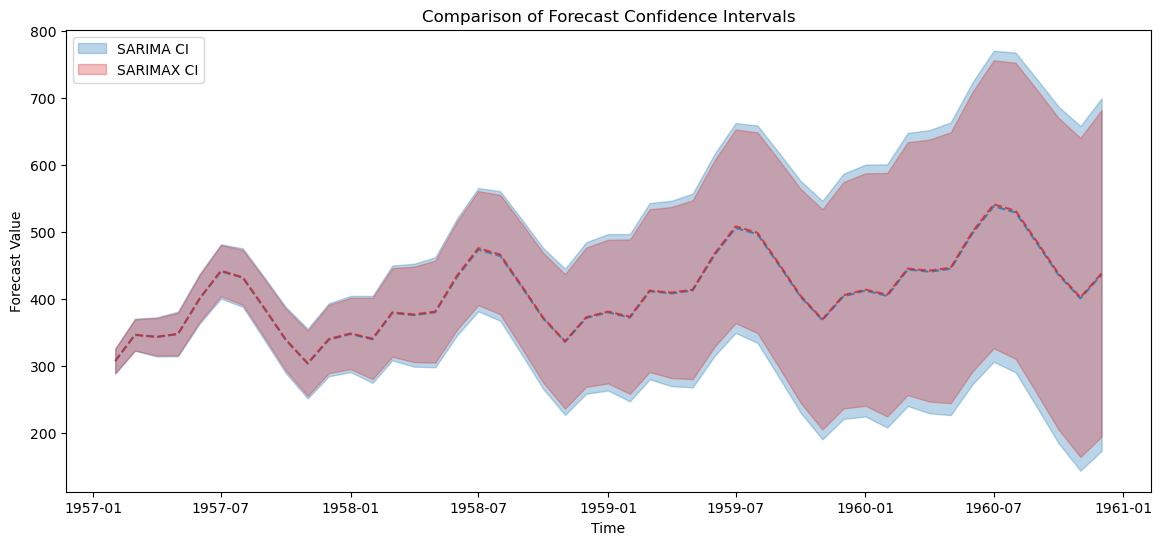

In [39]:
plt.figure(figsize=(14,6))
# Confidence interval SARIMA
plt.fill_between(
    preds_sarima.index,
    preds_sarima['mean_ci_lower'],
    preds_sarima['mean_ci_upper'],
    color='#1f77b4',
    alpha=0.3,
    edgecolor='#1f77b4',
    linewidth=1,
    label='SARIMA CI'
)

# Confidence interval SARIMAX
plt.fill_between(
    preds_sarimax.index,
    preds_sarimax['mean_ci_lower'],
    preds_sarimax['mean_ci_upper'],
    color='#d62728',
    alpha=0.3,
    edgecolor='#d62728',
    linewidth=1,
    label='SARIMAX CI'
)

# Average predictions
plt.plot(preds_sarima['mean'], color='#1f77b4', linestyle='--', alpha=0.8)
plt.plot(preds_sarimax['mean'], color='#d62728', linestyle='--', alpha=0.8)

plt.title("Comparison of Forecast Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Forecast Value")
plt.legend(loc="upper left")
plt.show()

By comparing the two confidence interval, we can note that the confidence interval of the SARIMAX model is shrinking w.r.t. SARIMA model. Thus, SARIMAX predictions are more robust thank to the exogenous variable in this case.